# Datenanalyse der Brettspielwelt-DB

## 2. Score-Differenzen skalieren

Die Score-Differenz ist ein nummerischer kontinuierlicher Wert.

**Theoretischer Bereich**, aber extrem unwahrscheinlich: [-800, 800]

* Die Punkte am Ende einer Runde ohne Bonus liegen
  * bei normalem Sieg: zw. -25 (nur Phönix kassiert) und 125 (alle Punkte außer Phönix kassiert).
    * bei Doppelsieg: zw. 0 (Doppelsieg verloren) + 200 (Doppelsieg gewonnen).
    * => Die maximal mögliche Differenz: 200.
  * Der Bonus für Tichu liegt zw. -400 (2 x großes Tichu verloren) und 200 (großes Tichu gewonnen).
 * => Die mögliche Differenz durch Bonus: 600.

**Datenmenge:** 22.437.758 Werte aus fehlerfreien Runden

**Vorgehen:**
1. Daten abfragen
2. Visuelle Datenanalyse: Histogramm und Q-Q-Plot erstellen.
3. Numerische Datenanalyse: Statistische Kennwerte berechnen
4. Clipping: Ausreißer entfernen (Datensätze löschen).
5. Skalieren: Werte in einem kleinen Bereich um 0 überführen.

**Analyseergebnis**

*  **Clipping**: Die langen Schwänze im Histogramm zeigen, dass es extreme Werte gibt. Das Clipping auf Basis der Perzentile 1% und 99% ist eine gute Wahl (Begrenzt die Score-Differenz auf den Bereich [-400, 400]).
*  **Skalierungsstrategie**: Die Diagramme bestätigen, dass eine einfache Normalisierung (Min-Max) eine schlechte Idee wäre. Die Ausreißer und die vielen Gipfel würden die Daten verzerren. Die Standardisierung (Z-Score), die die Form der Verteilung berücksichtigt, ist hier der richtige Weg:
   * Formel: `score_diff_scale = (score_diff - mittelwert) / standardabweichung`
     * Mittelwert: 7,379761382576637 = 7,38
     * Standardabweichung: 213,6506967698578 = 213,65
*  **Sonstiges**: Die Analyse der 20 Millionen Runden ergab eine leichte, aber statistisch signifikante Tendenz zugunsten von Team 20 mit einer durchschnittlichen Score-Differenz von +7,38!


### 2.1 Daten abfragen

In [69]:
%%sql
select score_diff from rounds where error_code = 0

,score_diff
0,-50
1,190
2,400
3,130
4,-200
...,...
22437753,50
22437754,170
22437755,80
22437756,400


### 2.2 Visuelle Datenanalyse

#### 2.2.1 Histogramm (Verteilungsdiagramm)

Ein Histogramm zeigt die Häufigkeit von Werten in einem Datensatz – also wie oft Werte in bestimmten Intervallen (Bins) vorkommen.

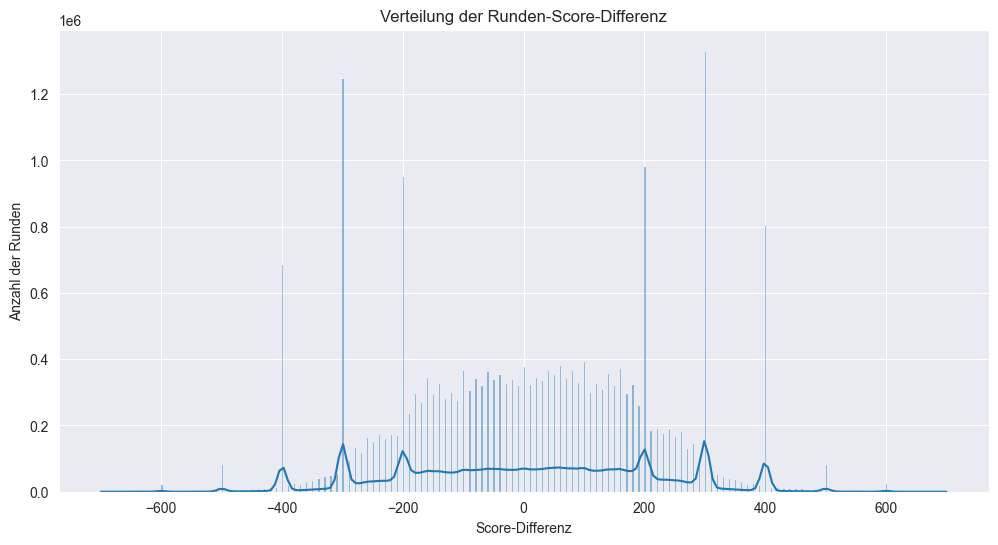

In [70]:
# Histogramms

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(df1['score_diff'], bins=700, kde=True)
plt.title('Verteilung der Runden-Score-Differenz')
plt.xlabel('Score-Differenz')
plt.ylabel('Anzahl der Runden')
plt.grid(True)
plt.show()

**Was ein Histogramm zeigt:**

*   **Die Balken:** Jeder Balken zeigt, wie viele Runden (Anzahl auf der Y-Achse) in einem bestimmten Bereich der Score-Differenz geendet haben.
*   **Die Kurve (KDE - Kernel Density Estimate):** Eine geglättete Version des Histogramms, die die Form der Verteilung verdeutlicht.

**Interpretation des Histogramms:**

Dieses Histogramm ist keine einfache Glockenkurve.

*   **Multimodale Verteilung:** Die Verteilung hat mehrere Gipfel (Modi), nicht nur einen in der Mitte. Das ist ein starkes Anzeichen dafür, dass es verschiedene "Arten" von Runden-Ergebnissen gibt.
*   **Der zentrale "Hügel":** Zwischen ca. -100 und +100 sehen wir den "normalen" Verlauf von Runden, in denen nur die Kartenpunkte zählen und es keine Tichu-Ansagen gab. Die Summe der Punkte ist hier immer 100, also kann die Differenz nicht größer als 100 sein (z.B. 100 zu 0 oder 0 zu 100).
*   **Die Spitzen bei +200 und -200:** Das sind die Doppelsiege! Ein Doppelsieg ergibt exakt 200 Punkte für ein Team und 0 für das andere, also eine Differenz von +200 oder -200. Die riesige Anzahl an Runden, die genau bei diesen Werten enden, zeigt, wie häufig Doppelsiege im Vergleich zu anderen hohen Scores sind.
*   **Die Spitzen bei +300 und -300:** Das ist höchstwahrscheinlich ein Doppelsieg (+200) kombiniert mit einem gewonnenen einfachen Tichu (+100).
*   **Die Spitzen bei +400 und -400:** Das ist höchstwahrscheinlich ein Doppelsieg (+200) kombiniert mit einem gewonnenen großen Tichu (+200).
Andere bemerkenswerte Spitzen:
*   **Die Gipfel um +100 und -100:** Das sind wahrscheinlich normale Runden, in denen ein Team Tichu gewinnt (+100) oder verliert (-100).
*   **Die Gipfel um +125 und -75** (Beispiel): Diese "ungeraden" 25er-Schritte entstehen durch den Drachen (+25) und den Phönix (-25).
*   **Lange "Schwänze" (Tails):** Die Verteilung hat sehr lange Ausläufer bis über +/- 600. Das sind die seltenen, extremen Runden, z.B. wenn mehrere Tichus in einer Runde gewonnen/verloren werden.

#### 2.2.2 Q-Q-Plot (Quantile-Quantile-Plot)

Ein **Q-Q-Plot (Quantile-Quantile-Plot)** vergleicht die Quantile deiner Daten mit denen einer theoretischen Verteilung (meist Normalverteilung).

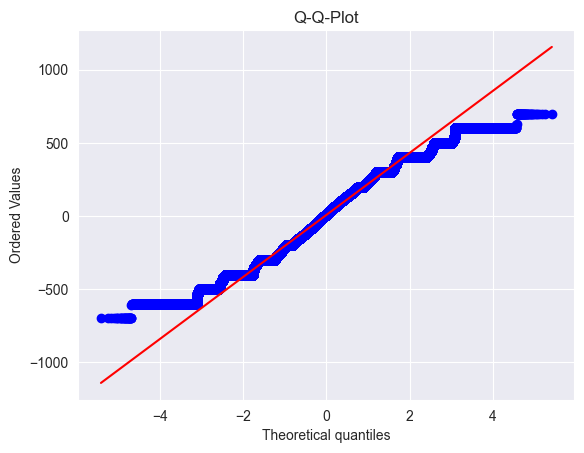

In [71]:
# Q-Q-Plot

import matplotlib.pyplot as plt
import scipy.stats as stats

stats.probplot(df1['score_diff'], dist="norm", plot=plt)
plt.title("Q-Q-Plot")
plt.grid(True)
plt.show()

**Was ein Q-Q-Plot zeigt**

Der Plot vergleicht die Quantile der Daten mit den theoretischen Quantilen einer Normalverteilung.

* Die rote Linie: Stellt die perfekte Normalverteilung dar. Wenn deine Daten perfekt normalverteilt wären, würden alle blauen Punkte genau auf dieser roten Linie liegen.
* Die blauen Punkte (deine Daten):
  * X-Achse ("Theoretical quantiles"): Zeigt an, wo ein Datenpunkt in einer perfekten Normalverteilung liegen würde (gemessen in Standardabweichungen vom Mittelwert).
  * Y-Achse ("Ordered Values"): Zeigt den tatsächlichen Wert deines Datenpunktes an (die score_diff).

**Interpretation des Q-Q-Plots**

* Im Zentrum (ca. -1.5 bis +1.5 auf der X-Achse):
  * Beobachtung: Die blauen Punkte schmiegen sich sehr gut an die rote Linie an.
  * Interpretation: Der "Hauptkörper" deiner Daten, also der Großteil der "normalen" Spielausgänge ohne extreme Ereignisse, verhält sich annähernd normalverteilt. Das ist eine wichtige Erkenntnis. Es gibt eine zentrale Tendenz, und die Abweichungen davon sind im Großen und Ganzen symmetrisch.
* An den Rändern ("Tails" / "Schwänze" der Verteilung):
  * Beobachtung: An beiden Enden weichen die blauen Punkte systematisch und stark von der roten Linie ab. Sie bilden eine Art "Treppenstufen"-Muster und liegen weit von der Linie entfernt.
  * Interpretation:
    * a) Die Daten haben "heavy tails" (schwere Ränder). Das bedeutet, extreme Werte (sehr hohe Gewinne/Verluste) kommen deutlich häufiger vor, als es bei einer reinen Normalverteilung der Fall wäre.
    * b) Jede horizontale Stufe repräsentiert eine große Anzahl von Datenpunkten, die exakt denselben Wert haben. Das sind unsere "Quanten-Spitzen" aus dem Histogramm! Zum Beispiel die lange horizontale Linie bei y=200 repräsentiert die Tausenden von Doppelsiegen, die alle denselben Score haben. In einer perfekten Normalverteilung gibt es keine solchen "Anhäufungen" an exakten Werten.

Die klare Schlussfolgerung aus diesem Plot ist: Die Verteilung deiner score_diff-Daten ist **NICHT normalverteilt**.

### 2.3 Nummerische Datenanalyse

#### 2.3.1 Statistischen Kennzahlen

In [89]:
# Berechne die wichtigsten statistischen Kennzahlen

#import pandas as pd
#import numpy as np

stats = df1['score_diff'].describe(percentiles=[0.005, .01, .05, .25, .75, .95, .99, .995])
#print(stats)

count = stats['count']
print(f"Anzahl der fehlerfreien Runden: {count}")

mean_score = stats['mean']
print(f"Mittelwert der Score-Differenz: {mean_score} = {mean_score:.02f}")

stdev_score = stats['std'] # .std() in Pandas verwendet standardmäßig ddof=1 (Stichprobe)
print(f"Standardabweichung: {stdev_score} = {stdev_score:.02f}")

min_score = stats['min']
max_score = stats['max']
print(f"Bereich der Score-Differenz: [{min_score:.0f}, {max_score:.0f}]")

p_0_5 = stats['0.5%']
p_99_5 = stats['99.5%']
print(f"99% aller Runden-Scores liegen zwischen {p_0_5:.0f} und {p_99_5:.0f}.")

p_1 = stats['1%']
p_99 = stats['99%']
print(f"98% aller Runden-Scores liegen zwischen {p_1:.0f} und {p_99:.0f}.")

p_5 = stats['5%']
p_95 = stats['95%']
print(f"90% aller Runden-Scores liegen zwischen {p_5:.0f} und {p_95:.0f}.")

p_25 = stats['25%']
p_75 = stats['75%']
print(f"50% aller Runden-Scores liegen zwischen {p_25:.0f} und {p_75:.0f}.")

# Gibt es Ausreißer?
has_outliers = (min_score < p_0_5 - stdev_score) or (max_score > p_99_5 + stdev_score)
if has_outliers:
    print("\nEs gibt signifikante Ausreißer in den Daten.")
else:
    print("\nDie Datenverteilung hat keine extremen Ausreißer.")

Anzahl der fehlerfreien Runden: 22437758.0
Mittelwert der Score-Differenz: 7.379761382576637 = 7.38
Standardabweichung: 213.6506967698578 = 213.65
Bereich der Score-Differenz: [-700, 700]
99% aller Runden-Scores liegen zwischen -480 und 490.
98% aller Runden-Scores liegen zwischen -400 und 400.
90% aller Runden-Scores liegen zwischen -310 und 340.
50% aller Runden-Scores liegen zwischen -160 und 180.

Es gibt signifikante Ausreißer in den Daten.


In [85]:
mean_score,

np.float64(7.352617405000981)

#### 2.3.2 Anderson-Darling-Test


Der Anderson-Darling-Test prüft, ob ein Datensatz normalverteilt ist.

- Der **Anderson-Darling-Test** eignet sich hervorragend für große Stichproben. Er gibt einen "Statistik"-Wert und kritische Werte auf verschiedenen Signifikanzniveaus (z. B. 1%, 5%, 10%). Man kann daraus ablesen, ob die Daten eine Normalverteilung aufweisen, indem man den Wert gegen die relevanten kritischen Werte vergleicht.
- Anders als der Shapiro-Wilk-Test skaliert der Anderson-Darling-Test mit einer Vielzahl von Datenpunkten.

In [73]:
# Anderson-Darling-Test für große Datenmengen

from scipy.stats import anderson

result = anderson(df1['score_diff'], dist='norm')

print("Statistik des Anderson-Darling-Tests:", result.statistic)
print("Kritische Werte für signifikantes Niveau und Ergebnis:")

for level, critical in zip(result.significance_level, result.critical_values):
    if result.statistic < critical:
        print(f"✅ p-Wert-Level {level}%: Daten sind normalverteilt (kritischer Wert: {critical:.2f})")
    else:
        print(f"❌ p-Wert-Level {level}%: Daten sind nicht normalverteilt (kritischer Wert: {critical:.2f})")

Statistik des Anderson-Darling-Tests: 83411.56294827908
Kritische Werte für signifikantes Niveau und Ergebnis:
❌ p-Wert-Level 15.0%: Daten sind nicht normalverteilt (kritischer Wert: 0.58)
❌ p-Wert-Level 10.0%: Daten sind nicht normalverteilt (kritischer Wert: 0.66)
❌ p-Wert-Level 5.0%: Daten sind nicht normalverteilt (kritischer Wert: 0.79)
❌ p-Wert-Level 2.5%: Daten sind nicht normalverteilt (kritischer Wert: 0.92)
❌ p-Wert-Level 1.0%: Daten sind nicht normalverteilt (kritischer Wert: 1.09)


#### 2.3.3 Daten tabellarisch sichten

In [74]:
# Gruppiere nach score_diff und zähle die Häufigkeiten
score_counts = df1['score_diff'].value_counts().sort_index()

# Konvertiere zu DataFrame für bessere Darstellung
score_counts_df = score_counts.reset_index()
#score_counts_df.columns = ['Score-Differenz', 'Anzahl']

score_counts_df

,score_diff,count
0,-700,31
1,-610,1
2,-600,20766
3,-590,4
4,-580,5
...,...,...
122,600,22627
123,610,1
124,620,2
125,630,1


### 2.4 Clipping

Ausreißer entfernen.

*    **Bei Normalisierung:** Clipping ist essenziell. Ein Fehler könnte zu einem absurden Wert von z.B. 9999 führen. 
     Ohne Clipping würde dieser eine Datenpunkt deine gesamte Statistik (min, max, mean, std_dev) zerstören und das Training ruinieren. 
*    **Bei Standardisierung:** Clipping ist sehr nützlich. Es verhindert, dass extreme Ausreißer den Mittelwert und 
     die Standardabweichung verzerren. Wenn der Mittelwert und die Standardabweichung stabiler sind, ist die resultierende 
     Skalierung für die Mehrheit der Daten aussagekräftiger.

**[-400, 400]) ist hier ein vernünftiger Bereich (Doppelsieg + Großes Tichu), also 1%- und 99%-Perzentile.**

In [75]:
# Clipping der Score-Differenzen auf den Bereich [-400, 400]

# SQL-Syntax: WHERE score BETWEEN p1 AND p99
df1['score_diff_clipped'] = df1['score_diff'].clip(lower=p_1, upper=p_99)

# Kennzahlen nach dem Clipping
stats = df1['score_diff_clipped'].describe()
mean_score = stats['mean']
std_dev_score = stats['std'] # .std() in Pandas verwendet standardmäßig ddof=1 (Stichprobe)
min_score = stats['min']
max_score = stats['max']
print(f"Mittelwert: {mean_score:.2f}")
print(f"Standardabweichung: {std_dev_score:.2f}")
print(f"Bereich: [{min_score}, {max_score}]")

Mittelwert: 7.35
Standardabweichung: 210.57
Bereich: [-400.0, 400.0]


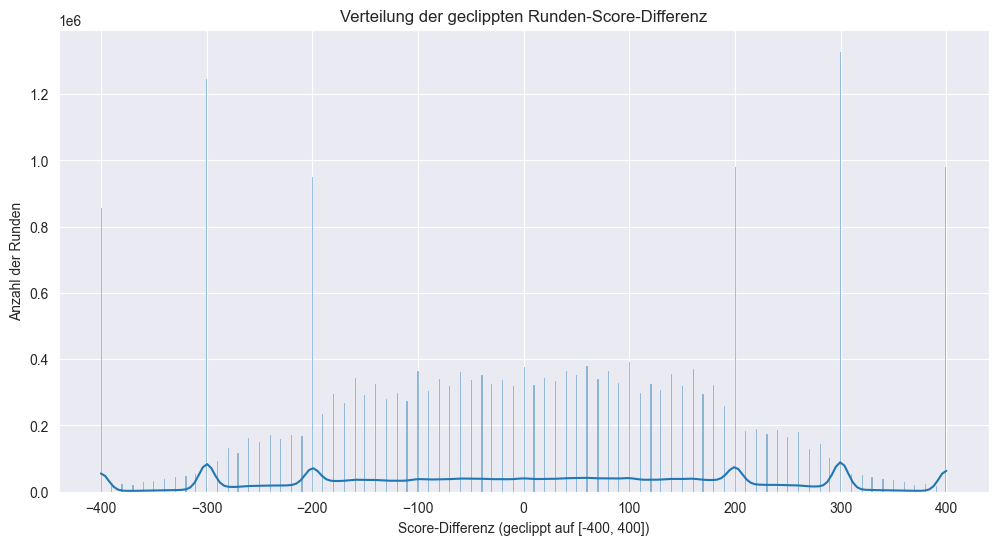

In [76]:
# Histogram Visualisierung der Verteilungen

plt.figure(figsize=(12, 6))
sns.histplot(data=df1, x='score_diff_clipped', bins=700, kde=True)
plt.title('Verteilung der geclippten Runden-Score-Differenz')
plt.xlabel('Score-Differenz (geclippt auf [-400, 400])')
plt.ylabel('Anzahl der Runden')
plt.grid(True)
plt.show()

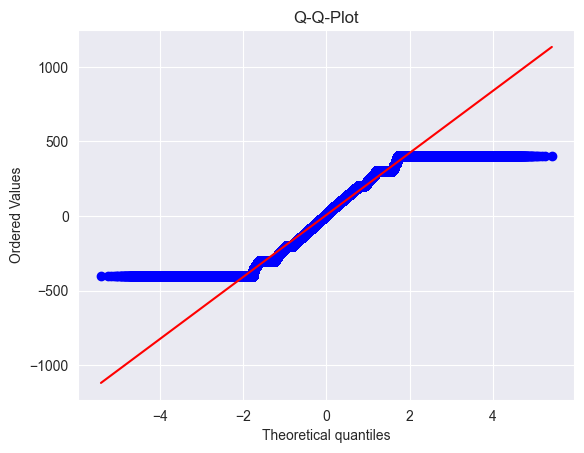

In [84]:
# Q-Q-Plot

import matplotlib.pyplot as plt
import scipy.stats as stats

stats.probplot(df1['score_diff_clipped'], dist="norm", plot=plt)
plt.title("Q-Q-Plot")
plt.grid(True)
plt.show()

### 2.5 Skalieren

Warum ist Skalieren notwendig?

Neuronale Netze funktionieren am besten mit Zahlen, die in einem kleinen Bereich um 0 liegen (typischerweise
zwischen -1 und 1 oder 0 und 1). Wenn deine Zielwerte aber z.B. im Bereich von -400 bis +400 liegen, sind die
Fehler (`loss = (vorhersage - ziel)^2`) riesig (z.B. `(100 - (-200))^2 = 90000`). Diese riesigen Fehlerwerte
führen zu extrem großen Gradienten (Anpassungssignalen) während des Backpropagation-Prozesses.

Die Folge (**Exploding Gradients**): Die Gewichte des Netzes werden bei jedem Schritt massiv geändert. Das
Training wird instabil, die Gewichte können "explodieren" (ins Unendliche wachsen), und das Modell lernt gar nichts.

Wie skaliert man am besten? Es gibt zwei Hauptmethoden: Normalisierung und Standardisierung.

*   Normalisierung (Min-Max-Skalierung im Bereich [0, 1]):
    *   Formel: `skalierter_wert = (wert - min_wert) / (max_wert - min_wert)`
    *   Ergebnis: Alle Werte liegen exakt zwischen 0 und 1.

*   Normalisierung (Min-Max-Skalierung im Bereich [-1, 1]):
    *   Formel: `skalierter_wert = 2 * ((wert - min_wert) / (max_wert - min_wert)) - 1`
    *   Ergebnis: Alle Werte liegen exakt zwischen 1- und 1 (die Daten sind um den Nullpunkt zentriert)

*   Standardisierung (Z-Score-Skalierung):
    *   Formel: `skalierter_wert = z_score = (wert - mittelwert) / standardabweichung`
    *   Ergebnis: Die skalierten Werte haben einen Mittelwert von 0 und eine Standardabweichung von 1. Die meisten Werte liegen typischerweise zwischen -3 und +3.

**Faustregel: Welche Method sollte man nehmen?**

*   Haben die Daten eine natürliche, feste Begrenzung und kaum Ausreißer (z.B. Bildpixel, Prozentsätze)? -> Normalisierung (Min-Max) ist eine gute Option.

*   Haben die Daten keine feste Begrenzung, eine glockenförmige (auch nicht-normale) Verteilung und/oder Ausreißer (z.B. Scores, Geldbeträge, Messwerte)? -> Standardisierung (Z-Score) ist fast immer die bessere, robustere Wahl.

**Somit ist Z-Score (Standardisierung) hier die richtige Wahl.**

In [81]:
# Skalierung – Z-Score (Standardisierung)
# SQL-Syntax: (score - avg) / stddev

stats = df1['score_diff_clipped'].describe()
df1['score_diff_scale'] = (df1['score_diff_clipped'] - stats['mean']) / stats['std']

# Kennzahlen der standardisierten Werte
stats = df1['score_diff_scale'].describe()
print(f"Mittelwert (sollte ~0 sein): {stats['mean']:.6f}")
print(f"Standardabweichung (sollte ~1 sein): {stats['std']:.6f}")
print(f"Bereich: [{stats['min']:.2f}, {stats['max']:.2f}]")

Mittelwert (sollte ~0 sein): 0.000000
Standardabweichung (sollte ~1 sein): 1.000000
Bereich: [-1.93, 1.86]


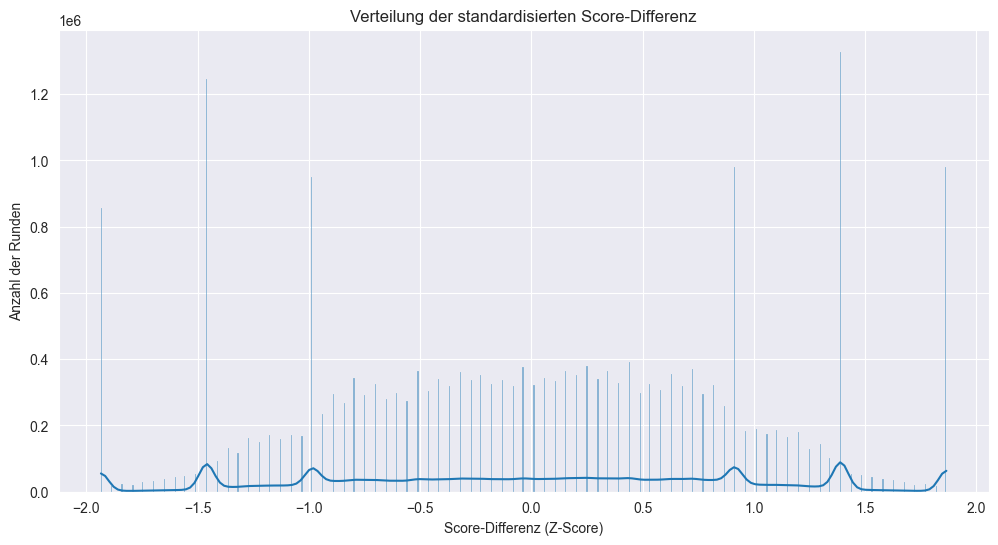

In [82]:
# Verteilung visualisieren
plt.figure(figsize=(12, 6))
sns.histplot(data=df1, x='score_diff_scale', bins=700, kde=True)
plt.title('Verteilung der standardisierten Score-Differenz')
plt.xlabel('Score-Differenz (Z-Score)')
plt.ylabel('Anzahl der Runden')
plt.grid(True)
plt.show()

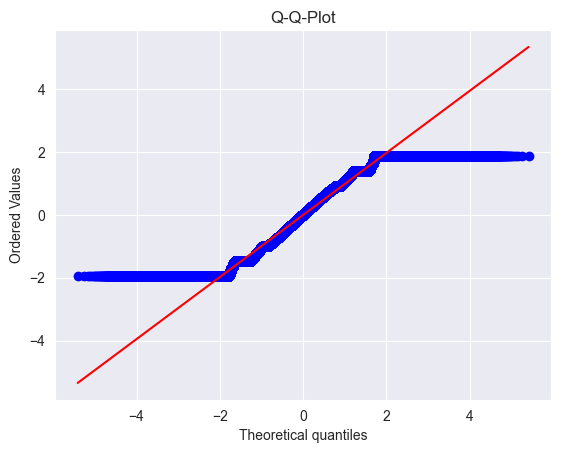

In [83]:
# Q-Q-Plot
import matplotlib.pyplot as plt
import scipy.stats as stats

stats.probplot(df1['score_diff_scale'], dist="norm", plot=plt)
plt.title("Q-Q-Plot")
plt.grid(True)
plt.show()